In [ ]:
Modelo que PREDICE si un hospital va a colapsar en una determinada fecha o no

\

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Importacion y manipulacion del dataset**

In [ ]:
base_path = '/content/gdrive/MyDrive/MLP-IA2/'

# Cargar los CSV
slots_df = pd.read_csv(base_path + 'slots.csv')
patients_df = pd.read_csv(base_path + 'patients.csv')
appointments_df = pd.read_csv(base_path + 'appointments.csv')


In [ ]:
print("Slots")
display(slots_df.head())

print("Patients")
display(patients_df.head())

print("Appointments")
display(appointments_df.head())

Slots


,slot_id,appointment_date,appointment_time,is_available
0,1,2015-01-01,08:00:00,False
1,2,2015-01-01,08:15:00,False
2,3,2015-01-01,08:30:00,False
3,4,2015-01-01,08:45:00,False
4,5,2015-01-01,09:00:00,False


Patients


,patient_id,name,sex,dob,insurance
0,1,Allison Hill,Female,1946-12-30,Mediflora Nexus
1,2,Nancy Rhodes,Female,1969-02-21,BioCrest Harmony
2,3,Angie Henderson,Female,1952-01-09,BioCrest Harmony
3,4,Colleen Wagner,Female,1981-01-28,BioCrest Harmony
4,5,Christina Santos,Female,1989-05-19,CurativeWhale


Appointments


/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,appointment_id,slot_id,scheduling_date,appointment_date,appointment_time,scheduling_interval,status,check_in_time,appointment_duration,start_time,end_time,waiting_time,patient_id,sex,age,age_group
0,138,1,2014-12-28,2015-01-01,08:00:00,4,did not attend,NaN,NaN,NaN,NaN,NaN,8285,Male,37,35-39
1,146,23,2014-12-29,2015-01-01,13:30:00,3,did not attend,NaN,NaN,NaN,NaN,NaN,5972,Male,84,80-84
2,21,24,2014-12-17,2015-01-01,13:45:00,15,attended,13:36:45,5.2,13:37:57,13:43:09,1.2,6472,Male,77,75-79
3,233,25,2014-12-31,2015-01-01,14:00:00,1,attended,13:59:32,28.9,14:00:40,14:29:34,1.1,5376,Female,37,35-39
4,90,26,2014-12-26,2015-01-01,14:15:00,6,cancelled,NaN,NaN,NaN,NaN,NaN,8028,Male,72,70-74


In [ ]:
# Unimos Appointments con Slots por 'slot_id'
merged_df = pd.merge(appointments_df, slots_df, on='slot_id', how='left')

# Unimos el resultado con Patients por 'patient_id'
full_df = pd.merge(merged_df, patients_df, on='patient_id', how='left', suffixes=('', '_patient'))

# Mostramos las primeras 5 filas
display(full_df.head())


,appointment_id,slot_id,scheduling_date,appointment_date_x,appointment_time_x,scheduling_interval,status,check_in_time,appointment_duration,start_time,...,sex,age,age_group,appointment_date_y,appointment_time_y,is_available,name,sex_patient,dob,insurance
0,138,1,2014-12-28,2015-01-01,08:00:00,4,did not attend,NaN,NaN,NaN,...,Male,37,35-39,2015-01-01,08:00:00,False,Thomas Garcia,Male,1977-11-09,MediSpectra Flux
1,146,23,2014-12-29,2015-01-01,13:30:00,3,did not attend,NaN,NaN,NaN,...,Male,84,80-84,2015-01-01,13:30:00,False,Kyle Moss,Male,1930-10-07,CurativeWhale
2,21,24,2014-12-17,2015-01-01,13:45:00,15,attended,13:36:45,5.2,13:37:57,...,Male,77,75-79,2015-01-01,13:45:00,False,Thomas Williams,Male,1937-06-21,Vitalynx Orbit
3,233,25,2014-12-31,2015-01-01,14:00:00,1,attended,13:59:32,28.9,14:00:40,...,Female,37,35-39,2015-01-01,14:00:00,False,Jaclyn Lindsey,Female,1977-05-14,Heliospring Vital
4,90,26,2014-12-26,2015-01-01,14:15:00,6,cancelled,NaN,NaN,NaN,...,Male,72,70-74,2015-01-01,14:15:00,True,Mathew Olson,Male,1942-11-06,HealthZenotron


In [ ]:
full_df = full_df.drop(columns=[
    'appointment_date_y',
    'appointment_time_y',
    'sex_patient',
    'dob',
    'appointment_id',
    'slot_id',
    'scheduling_date',
    'check_in_time',
    'start_time',
    'end_time',
    'name',
    'insurance',
    'age_group',
    'appointment_time',  # descartamos esta que no usamos
    'scheduling_interval', # descartamos también esta
    'sex',  # descartamos esta
    'age',  # descartamos esta
    'is_available'  # descartamos esta
], errors='ignore')

# Renombramos columnas para más claridad si existen
if 'appointment_date_x' in full_df.columns:
    full_df = full_df.rename(columns={'appointment_date_x': 'appointment_date'})
if 'appointment_time_x' in full_df.columns:
    full_df = full_df.rename(columns={'appointment_time_x': 'appointment_time'})

display(full_df.head())


,appointment_date,status,appointment_duration,waiting_time,patient_id
0,2015-01-01,did not attend,NaN,NaN,8285
1,2015-01-01,did not attend,NaN,NaN,5972
2,2015-01-01,attended,5.2,1.2,6472
3,2015-01-01,attended,28.9,1.1,5376
4,2015-01-01,cancelled,NaN,NaN,8028


# **Finalizacion del dataset y criterios a tomar en cuenta para el colapso o no**

Alta demanda de citas:
Más de 70 citas agendadas en ese día. Esto indica que la carga de pacientes es muy alta, lo que puede saturar recursos y personal.

Alta tasa de no presentación (no-show):
Más del 40% de los pacientes no se presentan a sus citas. Esto afecta la planificación y puede generar desorden o tiempos muertos inesperados.

Tiempo promedio de espera prolongado:
Los pacientes esperan en promedio más de 35 minutos para ser atendidos, señal de un sistema lento o saturado.

Carga acumulada excesiva en duración de citas:
La suma total de la duración de todas las citas del día supera las 660 minutos (11 horas). Esto indica que los recursos están trabajando mucho tiempo continuo, casi sin descanso.

Si menos de 2 condiciones se cumplen → el día se considera Normal (0).

Si 2 o más condiciones se cumplen → el día se considera en Colapso (1), mostrando estrés significativo en el sistema de citas médicas.

In [ ]:
# Agrupamos por fecha y calculamos las métricas
daily_stats = full_df.groupby('appointment_date').agg(
    total_citas        = ('patient_id', 'count'),
    pct_no_show        = ('status', lambda x: (x == 'no-show').mean()),
    avg_waiting_time   = ('waiting_time', 'mean'),
    total_duracion     = ('appointment_duration', 'sum')
).reset_index()

# Función binaria con umbrales más estrictos
def clasificar_binario(row):
    c = 0
    if row['total_citas']      > 70:   c += 1
    if row['pct_no_show']      > 0.40: c += 1
    if row['avg_waiting_time'] > 35:   c += 1
    if row['total_duracion']   > 660:  c += 1
    return 1 if c >= 2 else 0

daily_stats['Colapso'] = daily_stats.apply(clasificar_binario, axis=1)

# Vemos la distribución
print(daily_stats['Colapso'].value_counts())
display(daily_stats.head())




Colapso
0    2222
1     382
Name: count, dtype: int64


,appointment_date,total_citas,pct_no_show,avg_waiting_time,total_duracion,Colapso
0,2015-01-01,42,0.0,15.344444,476.4,0
1,2015-01-02,45,0.0,35.175758,605.8,0
2,2015-01-05,44,0.0,49.525714,647.3,0
3,2015-01-06,41,0.0,9.203333,481.1,0
4,2015-01-07,44,0.0,75.159459,656.6,0


In [ ]:
# Revisar cuántos NaN hay en cada columna
print(X.isna().sum())

# Eliminar filas con NaN
X_clean = X.dropna()
y_clean = y[X_clean.index]



total_citas          0
pct_no_show          0
avg_waiting_time    17
total_duracion       0
dtype: int64


# **Preparacion de datos y MLP**

In [ ]:

# === 1. Preparar X como NumPy array y añadir ruido ===
np.random.seed(42)
X_noisy = X_clean.to_numpy().astype(float)  # convierte a array
noise_level = 0.10
X_noisy += noise_level * np.random.normal(size=X_noisy.shape)

# Agregar ruido dirigido en avg_waiting_time (columna índice 2)
directed_noise = 0.5
X_noisy[:, 2] += directed_noise * np.random.normal(size=X_noisy.shape[0])

In [ ]:
# === 2. División de datos ===
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y_clean.to_numpy(), test_size=0.2, random_state=42, stratify=y_clean
)

# === 3. Escalado ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
# === 4. MLP con regularización, early stopping y más capas ===
mlp_tuned = MLPClassifier(
    hidden_layer_sizes=(15, 10, 5),  # más capas ocultas
    alpha=0.1,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    max_iter=500,
    random_state=42
)
mlp_tuned.fit(X_train_scaled, y_train)


MLPClassifier(alpha=0.1, early_stopping=True, hidden_layer_sizes=(15, 10, 5),
              max_iter=500, n_iter_no_change=20, random_state=42)

In [ ]:
# === 5. Evaluación en test ===
y_pred = mlp_tuned.predict(X_test_scaled)
print("=== MLP Tuned con Early Stopping y Más Capas ===")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# === 6. Validación cruzada ===
cv_scores = cross_val_score(
    mlp_tuned,
    scaler.transform(X_noisy),
    y_clean.to_numpy(),
    cv=5,
    scoring='f1'
)
print(f"Cross-validation F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


=== MLP Tuned con Early Stopping y Más Capas ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       442
           1       0.99      0.91      0.95        76

    accuracy                           0.98       518
   macro avg       0.99      0.95      0.97       518
weighted avg       0.98      0.98      0.98       518

[[441   1]
 [  7  69]]
Cross-validation F1: 0.9776 ± 0.0156


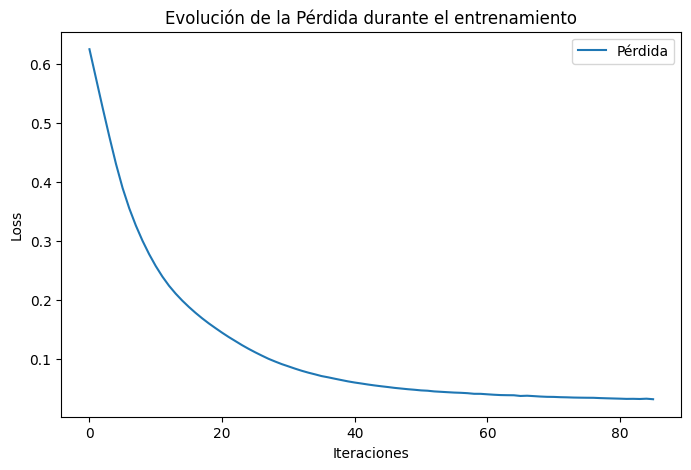

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(mlp_tuned.loss_curve_, label='Pérdida')
plt.title('Evolución de la Pérdida durante el entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Loss')
plt.legend()
plt.show()

